In [1]:
# -*- coding: utf-8 -*-
"""
Cleaned & improved pipeline for Tuberculosis X-ray classification.
Key fixes vs original:
- Removed SMOTE on flattened images (inappropriate for images).
- Added robust image loading with checks.
- Stratified Train/Val/Test split.
- On-the-fly image augmentation with Keras preprocessing layers.
- Proper callbacks: EarlyStopping & ReduceLROnPlateau monitoring val_loss.
- Class weights for imbalance (optional but enabled).
- Clear metrics, confusion matrix, PR curve, and training plots with validation.
- Single model definition (no duplicates).
"""

'\nCleaned & improved pipeline for Tuberculosis X-ray classification.\nKey fixes vs original:\n- Removed SMOTE on flattened images (inappropriate for images).\n- Added robust image loading with checks.\n- Stratified Train/Val/Test split.\n- On-the-fly image augmentation with Keras preprocessing layers.\n- Proper callbacks: EarlyStopping & ReduceLROnPlateau monitoring val_loss.\n- Class weights for imbalance (optional but enabled).\n- Clear metrics, confusion matrix, PR curve, and training plots with validation.\n- Single model definition (no duplicates).\n'

In [2]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
)
from collections import Counter

In [3]:
# ------------------------------
# 1) Dataset acquisition (KaggleHub) and paths
# ------------------------------
try:
    import kagglehub
    path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")
    print("Path to dataset files:", path)
except Exception as e:
    print("KaggleHub not available or dataset already present:", e)

Path to dataset files: /kaggle/input/tuberculosis-tb-chest-xray-dataset


In [4]:
# # Update these if your cache path differs
# BASE = os.path.expanduser("~/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database")
# NORMAL_DIR = os.path.join(BASE, "Normal")
# TB_DIR = os.path.join(BASE, "Tuberculosis")
NORMAL_DIR = os.path.join(path, "TB_Chest_Radiography_Database", "Normal")
TB_DIR = os.path.join(path, "TB_Chest_Radiography_Database", "Tuberculosis")

In [5]:
IMG_SIZE = 256
SEED = 42
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
# ------------------------------
# 2) Robust image loading
# ------------------------------
def load_images_from_dir(directory, label, img_size=256, limit=None):
    imgs, labels = [], []
    if not os.path.isdir(directory):
        print(f"WARNING: Directory not found -> {directory}")
        return np.array(imgs), np.array(labels)
    count = 0
    for fname in os.listdir(directory):
        fpath = os.path.join(directory, fname)
        if not os.path.isfile(fpath):
            continue
        image = cv.imread(fpath, cv.IMREAD_GRAYSCALE)
        if image is None:
            # Skip corrupt/unreadable files
            continue
        try:
            image = cv.resize(image, (img_size, img_size), interpolation=cv.INTER_AREA)
        except Exception:
            continue
        imgs.append(image)
        labels.append(label)
        count += 1
        if limit is not None and count >= limit:
            break
    return np.array(imgs), np.array(labels)

In [7]:
normal_imgs, normal_labels = load_images_from_dir(NORMAL_DIR, 0, IMG_SIZE)
tb_imgs, tb_labels = load_images_from_dir(TB_DIR, 1, IMG_SIZE)

In [8]:
images = np.concatenate([normal_imgs, tb_imgs], axis=0)
labels = np.concatenate([normal_labels, tb_labels], axis=0).astype(np.int32)

In [9]:
print("Total images loaded:", images.shape[0])
print("Class distribution:", Counter(labels))

Total images loaded: 4200
Class distribution: Counter({np.int32(0): 3500, np.int32(1): 700})


In [10]:
# Normalize to [0,1] and add channel dimension
images = images.astype("float32") / 255.0
images = np.expand_dims(images, axis=-1)  # (N, H, W, 1)

In [11]:
# ------------------------------
# 3) Stratified Train/Val/Test split
# ------------------------------
# First split train+val and test
X_tmp, X_test, y_tmp, y_test = train_test_split(
    images, labels, test_size=0.20, random_state=SEED, stratify=labels
)
# Then split train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.20, random_state=SEED, stratify=y_tmp
)

In [12]:
print("Shapes -> Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

Shapes -> Train: (2688, 256, 256, 1)  Val: (672, 256, 256, 1)  Test: (840, 256, 256, 1)


In [13]:
# ------------------------------
# 4) tf.data pipelines
# ------------------------------
# Data augmentation with Keras preprocessing layers keeps spatial structure
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.02),
    tf.keras.layers.RandomZoom(0.05),
], name="augmentation")

In [14]:
def make_ds(X, y, training=False, batch_size=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=True)
        # Map augmentation only during training
        ds = ds.map(lambda img, lbl: (data_augmentation(img, training=True), lbl),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [15]:
train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val, y_val, training=False)
test_ds  = make_ds(X_test, y_test, training=False)

In [16]:
# ------------------------------
# 5) Model
# ------------------------------
def build_model(img_size=256):
    inputs = tf.keras.Input(shape=(img_size, img_size, 1))
    x = tf.keras.layers.Conv2D(16, (3,3), activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs, name="tb_cnn")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

In [17]:
model = build_model(IMG_SIZE)
model.summary()

Model: "tb_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,709,825 (14.15 MB)

 Trainable params: 3,709,825 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# ------------------------------
# 6) Class weights to handle imbalance
# ------------------------------
class_counts = Counter(y_train)
total = sum(class_counts.values())
class_weight = {cls: total/(len(class_counts)*count) for cls, count in class_counts.items()}
print("Class weights:", class_weight)

Class weights: {np.int32(1): 3.0, np.int32(0): 0.6}


In [19]:
# ------------------------------
# 7) Callbacks (monitor validation loss)
# ------------------------------
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("best_tb_cnn.keras", monitor="val_loss", save_best_only=True, verbose=1),
]

In [20]:
# ------------------------------
# 8) Train
# ------------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.24893, saving model to best_tb_cnn.keras
168/168 - 25s - 150ms/step - accuracy: 0.7879 - auc: 0.8112 - loss: 0.5411 - val_accuracy: 0.9048 - val_auc: 0.9529 - val_loss: 0.2489 - learning_rate: 1.0000e-03
Epoch 2/10

Epoch 2: val_loss improved from 0.24893 to 0.17010, saving model to best_tb_cnn.keras
168/168 - 35s - 209ms/step - accuracy: 0.8475 - auc: 0.9064 - loss: 0.4046 - val_accuracy: 0.9449 - val_auc: 0.9662 - val_loss: 0.1701 - learning_rate: 1.0000e-03
Epoch 3/10

Epoch 3: val_loss did not improve from 0.17010
168/168 - 16s - 94ms/step - accuracy: 0.8828 - auc: 0.9430 - loss: 0.3111 - val_accuracy: 0.9241 - val_auc: 0.9767 - val_loss: 0.1782 - learning_rate: 1.0000e-03
Epoch 4/10

Epoch 4: val_loss improved from 0.17010 to 0.15503, saving model to best_tb_cnn.keras
168/168 - 21s - 125ms/step - accuracy: 0.8843 - auc: 0.9508 - loss: 0.2869 - val_accuracy: 0.9360 - val_auc: 0.9736 - val_loss: 0.1550 - learning_rate: 1.0000e-03


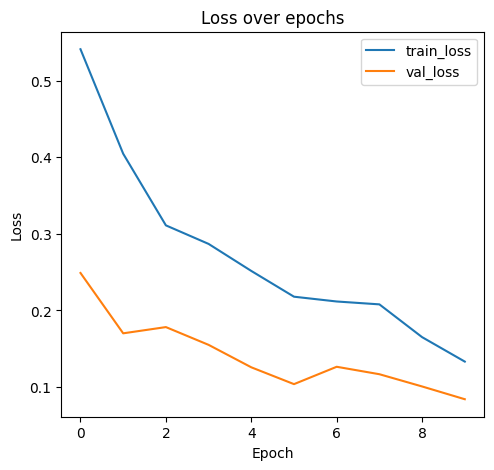

In [21]:
# ------------------------------
# 9) Training curves
# ------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Saved training_curves.png


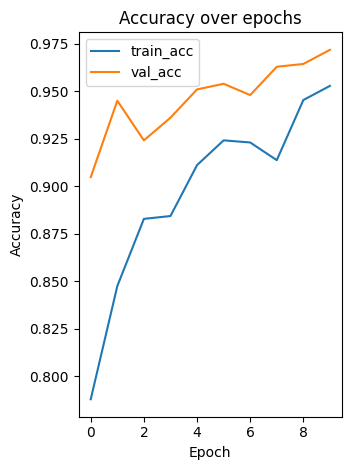

In [22]:
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("training_curves.png", dpi=150)
print("Saved training_curves.png")

In [23]:
# ------------------------------
# 10) Evaluate on test set
# ------------------------------
print("\nTEST RESULTS:")
test_metrics = model.evaluate(test_ds, verbose=0, return_dict=True)
print(test_metrics)


TEST RESULTS:
{'accuracy': 0.9595237970352173, 'auc': 0.9821274876594543, 'loss': 0.1093544289469719}


In [24]:
# Predictions & metrics
y_prob = model.predict(test_ds, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(np.int32)

In [25]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal","Tuberculosis"]))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       700
Tuberculosis       0.84      0.93      0.88       140

    accuracy                           0.96       840
   macro avg       0.91      0.95      0.93       840
weighted avg       0.96      0.96      0.96       840



In [26]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[676  24]
 [ 10 130]]


Saved confusion_matrix.png


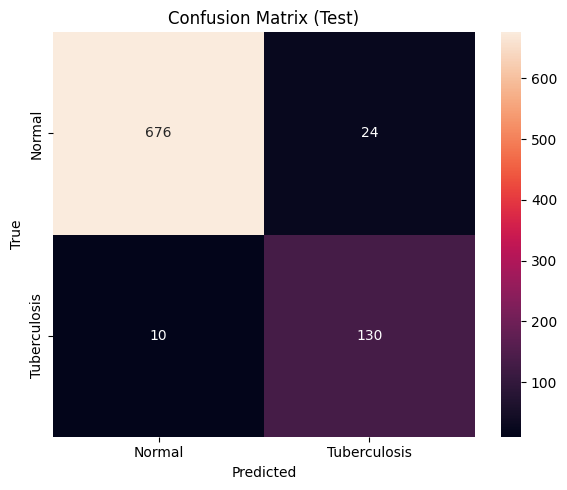

In [27]:
# Confusion matrix heatmap
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Normal","Tuberculosis"], yticklabels=["Normal","Tuberculosis"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
print("Saved confusion_matrix.png")

In [28]:
# Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

Saved precision_recall.png


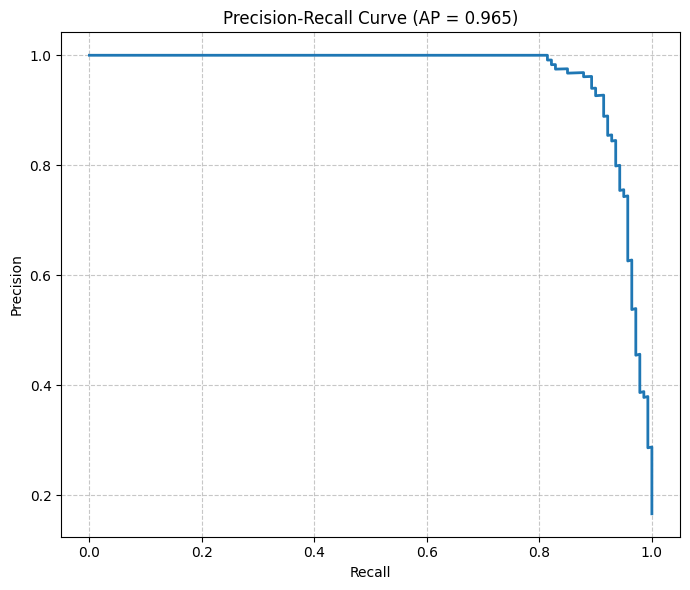

In [29]:
plt.figure(figsize=(7,6))
plt.plot(recall, precision, linewidth=2)
plt.title(f"Precision-Recall Curve (AP = {avg_precision:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("precision_recall.png", dpi=150)
print("Saved precision_recall.png")

In [30]:
# Save model architecture diagram
try:
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)
    print("Saved model_architecture.png")
except Exception as e:
    print("plot_model not available:", e)

Saved model_architecture.png
